# Investigating Fandango Movie Ratings

In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and suggested that Fandango's rating system was biased and dishonest ([Fandango](https://www.fandango.com/) is an online movie ratings aggregator). He published his analysis in [this article](https://fivethirtyeight.com/features/fandango-movies-ratings/).

Fandango displays a 5-star rating system on their website, where the minimum rating is 0 stars and the maximum is 5 stars. Hickey found that there's a significant discrepancy between the number of stars displayed to users and the actual rating, which he was able to find in the HTML of the page. He was able to find that:

- The actual rating was almost always rounded up to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.
- In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.
- For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars.

Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although we can't tell for sure since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.

In this project, I'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

I will compare the system's characteristics previous and after the analysis.

- Walt Hickey made the data he analyzed publicly available on [GitHub](https://github.com/fivethirtyeight/data/tree/master/fandango). We'll use the data he collected to analyze the characteristics of Fandango's rating system previous to his analysis.

- One of Dataquest's team members collected movie ratings data for movies released in 2016 and 2017. The data is publicly available on [GitHub](https://github.com/mircealex/Movie_ratings_2016_17) and we'll use it to analyze the rating system's characteristics after Hickey's analysis.

### Summary of results
There is a difference between the Fandango's rating of popular movies in 2015 and 2016. The rating in 2016 is lower than the rating in 2015.

- Both distributions of 2015 and 2016 movies are strongly left skewed.
- The 2016 distribution is shifted to left relative to 2015 distribution.
- The mean rating of 2016 movies drops 0.2, which means the average rating of 2016 movies is 5% lower than 2015. 
- The 2016 mode rating is 4.5 in 2016 and 4.0 in 2015.
- The median ratings of both years are the same

## Reading in data

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# read in two data sets
fandango = pd.read_csv('fandango_score_comparison.csv')
movies = pd.read_csv('movie_ratings_16_17.csv')

In [110]:
# explore data sets
fandango.info()
print()
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 22 columns):
FILM                          146 non-null object
RottenTomatoes                146 non-null int64
RottenTomatoes_User           146 non-null int64
Metacritic                    146 non-null int64
Metacritic_User               146 non-null float64
IMDB                          146 non-null float64
Fandango_Stars                146 non-null float64
Fandango_Ratingvalue          146 non-null float64
RT_norm                       146 non-null float64
RT_user_norm                  146 non-null float64
Metacritic_norm               146 non-null float64
Metacritic_user_nom           146 non-null float64
IMDB_norm                     146 non-null float64
RT_norm_round                 146 non-null float64
RT_user_norm_round            146 non-null float64
Metacritic_norm_round         146 non-null float64
Metacritic_user_norm_round    146 non-null float64
IMDB_norm_round               146 n

In [111]:
# extract related columns
fandango = fandango[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 
                     'Fandango_votes', 'Fandango_Difference']].copy()
movies = movies[['movie', 'year', 'fandango']].copy()

In [112]:
# display first 3 rows of the database
print(fandango.head(3))
print(movies.head(3))

                             FILM  Fandango_Stars  Fandango_Ratingvalue  \
0  Avengers: Age of Ultron (2015)             5.0                   4.5   
1               Cinderella (2015)             5.0                   4.5   
2                  Ant-Man (2015)             5.0                   4.5   

   Fandango_votes  Fandango_Difference  
0           14846                  0.5  
1           12640                  0.5  
2           12055                  0.5  
                 movie  year  fandango
0  10 Cloverfield Lane  2016       3.5
1             13 Hours  2016       4.5
2  A Cure for Wellness  2016       3.0


The goal of the project is to detemine if there is any change for the Fandango's rating system after Hicky's investigation. The population of interest for the analysis is made of all the movie ratings stored on Fandango's website, regardless of the releasing year. To do that, two data sets are needed, the Fangango ratings of movies before the publication of the investigation and the Fangango ratings of movies after the publication of the investigation.

From [the README.md](https://github.com/fivethirtyeight/data/blob/master/fandango/README.md) file and [Hickey's article](https://fivethirtyeight.com/features/fandango-movies-ratings/), the fandango data set contains samples filfulling the following two criterias:
- The movie must have at least 30 fan reviews on Fandango (Aug. 24, 2015).
- The movie must have had tickets on sale in 2015.

Because of these critirias, it's questionable that the samples can represent the entire population of interest.

For the movies data set, from the [README.md](https://github.com/mircealex/Movie_ratings_2016_17/blob/master/README.md) of the repository, it contains samples fulfilling the following two criterias:
- The movie is released in 2016 or 2017.
- The movie is with a significant number of votes (defination of significant is unclear)

It is also hard to say that the samples in this data set is representative for the whole population. 

## Changing the goal of the analysis

Due to the lack of representative sampling, I decided to to change the goal of the analysis.

Instead of determining if there is any change in Fandango's rating system after Hickey's investigation, i am going to find out whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. This new goal is also a possible proxy for the original goal.

With the new goal, there are two populations that I want to describe and compare with each other:

- All Fandango's ratings for popular movies released in 2015.
- All Fandango's ratings for popular movies released in 2016.

For the defination of popular movie, it's defined as the movies with at least 5000 user reviews on Rotten tomatos. 

For the two datasets, as they do not contain any information regarding the number of user review in rotten tomatos. I will randomly select 10 samples form the data sets and check if they fulfill the critecias of population.

## Isolating related data

In [113]:
# create column for release year and extract release year from film name
fandango['year'] = fandango['FILM'].str[-5:-1].astype(int)

# isolate movies released in 2015
fandango_15 = fandango[fandango['year'] == 2015]
print(fandango_15.info())

# random select 10 samples from the first data sets, random state set to 0
fandango_15.sample(10, random_state = 0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 0 to 145
Data columns (total 6 columns):
FILM                    129 non-null object
Fandango_Stars          129 non-null float64
Fandango_Ratingvalue    129 non-null float64
Fandango_votes          129 non-null int64
Fandango_Difference     129 non-null float64
year                    129 non-null int64
dtypes: float64(3), int64(2), object(1)
memory usage: 7.1+ KB
None


,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,year
48,Fantastic Four (2015),3.0,2.7,6288,0.3,2015
31,When Marnie Was There (2015),4.5,4.1,46,0.4,2015
123,Magic Mike XXL (2015),4.5,4.4,9363,0.1,2015
59,Mortdecai (2015),3.5,3.2,1196,0.3,2015
9,Love & Mercy (2015),4.5,4.0,864,0.5,2015
138,Spare Parts (2015),4.5,4.5,450,0.0,2015
52,The Age of Adaline (2015),4.5,4.2,3325,0.3,2015
120,The Wolfpack (2015),3.5,3.4,66,0.1,2015
85,Little Boy (2015),4.5,4.3,811,0.2,2015
8,Shaun the Sheep Movie (2015),4.5,4.0,896,0.5,2015


All the 10 samples have more than 5000 user ratings. The first data set fulfill the requirements.

| Film | Number of ratings |
| --- | --- |
| Fantastic Four | 137808 |
| When Marnie Was There | 6239 |
| Magic Mike XXL | 35016 |
| Mortdecai | 25313 |
| Love & Mercy | 19937 |
| Spare Parts | 6761 |
| The Age of Adaline | 38609 |
| The Wolfpack | 8766 |
| Little Boy | 8532 |
| Shaun the Sheep Movie | 22694 |

Let check the second data set.

In [114]:
# isolate movies released in 2016
fandango_16 = movies[movies['year'] == 2016]
print(fandango_16.info())

# random select 10 samples from the second data sets, random state set to 0
fandango_16.sample(10, random_state = 0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191 entries, 0 to 213
Data columns (total 3 columns):
movie       191 non-null object
year        191 non-null int64
fandango    191 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.0+ KB
None


,movie,year,fandango
121,Nerve,2016,4.0
83,Jane Got a Gun,2016,3.5
179,The Great Wall,2016,4.0
108,Mechanic: Resurrection,2016,4.0
136,Resident Evil: The Final Chapter,2016,4.0
80,Inferno,2016,3.5
22,Ben-Hur,2016,4.0
137,Ride Along 2,2016,4.0
160,The Angry Birds Movie,2016,4.0
8,Allied,2016,4.0


All the 10 samples have more than 5000 user ratings. The second data set also fulfill the requirements.

| Film | Number of ratings |
| --- | --- |
| Nerve | 24464 |
| Jane Got a Gun | 14059 |
| The Great Wall | 23740 |
| Mechanic: Resurrection | 25635 |
| Resident Evil: The Final Chapter | 59517 |
| Inferno | 28776 |
| Ben-Hur | 18999 |
| Ride Along 2 | 35056 |
| The Angry Birds Movie | 29438 |
| Allied | 25272 |

I will move on with the analysis.

## Comparing Distribution Shapes for 2015 and 2016

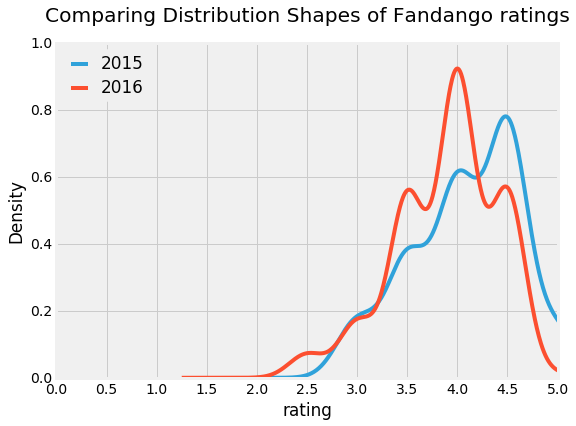

In [115]:
# generate two kernel density plots to compare the distribution of movie ratings of each samples
fandango_15['Fandango_Stars'].plot.kde(label = '2015', legend = True, figsize = (8, 6))
fandango_16['fandango'].plot.kde(label = '2016', legend = True)
plt.style.use('fivethirtyeight')
plt.title('Comparing Distribution Shapes of Fandango ratings', y =1.05 )
plt.xlabel('rating')
plt.xlim(0,5)
plt.xticks(arange(0,5.1,.5))
plt.show()

The findings are following:
- Both distributions are strongly left skewed.
- The 2016 distribution is shifted to left relative to 2015 distribution.

The left shew suggests that the movie ratings in Fandango tends to be given high or very high. But we can not jump to any conclusion only because of this, it may also happen on other movie rating websites. But as it is not the scope of the current project, I am not moving forward to investigate the reasons behind. 

The left shift of 2016 distribution sugguests that there is indeed a difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. Ans the direction of difference is: the ratings is slightly lower in 2016 compared to 2015. 

# Comparing Relative Frequencies

In [116]:
print('2015' + '\n' + '-' * 16)

# generate frequency distribution table for 2015 movies 
fandango_15['Fandango_Stars'].value_counts(normalize = True).sort_index() * 100

2015
----------------


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [117]:
print('2016' + '\n' + '-' * 16)

# generate frequency distribution table for 2016 movies 
fandango_16['fandango'].value_counts(normalize = True).sort_index() * 100

2016
----------------


2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

In 2015, the ratings focus on 4.0 and 4.5, nearly 40% of the movies get rated 4.5, which is the biggest proportion. In 2016, the ratings mainly concentrate between 3.5 and 4.5. 40% of the movies get rated 4.0, which is the biggest proportion. There is only 24.6% of the movies get rated 4.5. The difference and it's direction is clear. The rating in 2016 is lower than 2015.

# Determining the Direction of the Change

In this session, I am going to calculate the a couple of summary statistics (mean, mode and median) to get a more precise picture about the direction of the difference.

In [118]:
# calculate mean
mean_15 = fandango_15['Fandango_Stars'].mean()
mean_16 = fandango_16['fandango'].mean()

# calculate mode
mode_15 = fandango_15['Fandango_Stars'].mode()[0]
mode_16 = fandango_16['fandango'].mode()[0]

# calculate median
median_15 = fandango_15['Fandango_Stars'].median()
median_16 = fandango_16['fandango'].median()

# create Dataframe and put them together
summary = pd.DataFrame()
summary['2015'] = [mean_15, mode_15, median_15]
summary['2016'] = [mean_16, mode_16, median_16]
summary.index = ['mean', 'mode', 'median']
print(summary)

            2015      2016
mean    4.085271  3.887435
mode    4.500000  4.000000
median  4.000000  4.000000


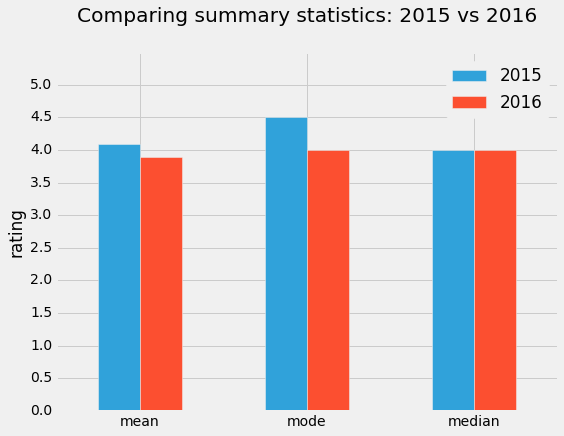

In [192]:
# plot grouped bar chart
plt.style.use('fivethirtyeight')
summary.plot.bar(rot = 0, figsize =(8, 6))
plt.title('Comparing summary statistics: 2015 vs 2016', y = 1.07)
plt.ylim(0,5.5)
plt.yticks(arange(0,5.1,.5))
plt.ylabel('rating')
plt.show()

The findings are following:
- The mean rating of 2016 movies drops 0.2, which means the average rating of 2016 movies is 5% lower than 2015. 
- The 2016 mode rating is 4.5 in 2016 and 4.0 in 2015.
- The median ratings of both years are the same

## Conclusion

It's concluded that there is a difference between the Fandango's rating of popular movies in 2015 and 2016. The rating in 2016 is lower than the rating in 2015.